<a href="https://colab.research.google.com/github/madelineekim/pytorch-basics/blob/main/02_pytorch_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Classification is a problem of predicting whether something is one thing or another

1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [5]:
#make pandas df
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0],
                         "X2": X[:,1],
                        "label": y})

circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


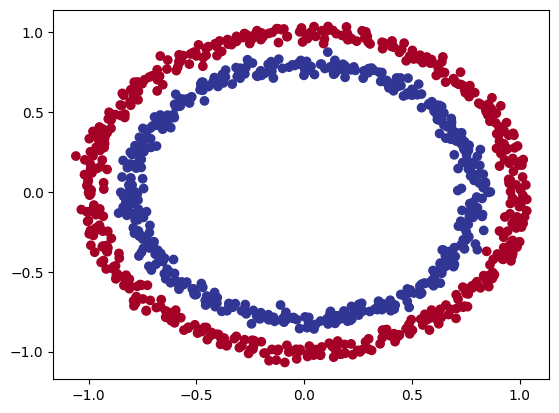

In [6]:
#Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

The data working with here is often called a toy dataset which is a dataset which is small enough to experiment with but still sizeable enough to practice the fundamentals

Check input and output shapes

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
X_sample = X[0]
y_sample = y[0]

X_sample, y_sample

(array([0.75424625, 0.23148074]), 1)

Turn data into tensors and create train/test splits

In [9]:
# Turn data into tensors
import torch
torch.__version__

'2.5.1+cu124'

In [10]:
X = torch.from_numpy(X).type(torch.float32)

In [11]:
y = torch.from_numpy(y).type(torch.float32)

In [12]:
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

Building a model:
* set up device agnostic code
* construct a model (by subclassing nn.Module)
* define a loss function and optimizer
* create a training and test loop

In [15]:
import torch
from torch import nn

# make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

* subclass nn.Module (almost all pytorch models do)
* create 2 nn.Linear layers that are capable of handling the shape of our data
* define a forward method that outlines the forward pass of the model
* instantiate an instance of our model class and send it to the target device

In [16]:
# construct model that subclasses nn.Module
class CircleModelv0(nn.Module):
  def __init__(self):
    super().__init__()
    # create two nn.Linear layers
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  #forward method
  def forward(self, x):
    return self.layer_2(self.layer_1(x))

# instantiate an instance of model class and send to target device
model_0 = CircleModelv0().to(device)
model_0


CircleModelv0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [18]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
# Make predictions
with torch.inference_mode():

  untrained_preds = model_0(X_test.to(device))
print(f"length of predictions: {len(untrained_preds)}")
print(f"shape of predictions: {untrained_preds.shape}")
print(f"first 10 predictions: {untrained_preds[:10]}")
print(f"first 10 labels: {y_test[:10]}")


length of predictions: 200
shape of predictions: torch.Size([200, 1])
first 10 predictions: tensor([[-0.3851],
        [-0.2307],
        [-0.4455],
        [-0.3695],
        [ 0.1012],
        [ 0.1913],
        [ 0.1927],
        [ 0.2929],
        [-0.4685],
        [-0.2143]], device='cuda:0')
first 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Set up loss function and optimizer

In [20]:
# set up loss function
loss_fn = nn.BCEWithLogitsLoss()

# set up optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [21]:
# calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

Train Model (build training loop):
* Forward pass
* Calculate loss
* Optimizer zero grad
* Loss backward
* Optimizer step

Our model outputs are going to be raw logits and we can convert them into prediction probabilities by passing them to a kind of activation function. Then we can convert those to prediction labels

In [24]:
# view first 5 outputs of forward pass on test data
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.3851],
        [-0.2307],
        [-0.4455],
        [-0.3695],
        [ 0.1012]], device='cuda:0')

In [25]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [26]:
# use the sigmoid activation function on our model logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4049],
        [0.4426],
        [0.3904],
        [0.4087],
        [0.5253]], device='cuda:0')

In [29]:
# find predicted labels
y_preds = torch.round(y_pred_probs)

# in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 1.], device='cuda:0')

In [30]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

Build training/testing loop

In [31]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 100

# put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# build training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # calculate loss and accuracy
  ## loss = loss_fn(torch.sigmoid(y_logits), y_train) ## nn.BCELoss expects prediction probabilities as input
  loss = loss_fn(y_logits, y_train) # nn.BCEWithLogitsLoss expects raw logits as input
  acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

  # optimizer zero grad
  optimizer.zero_grad()

  # loss backward
  loss.backward()

  # optimizer.step()
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():

    # forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # calculate test loss/acc
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

  # print out what's happening
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss: .5f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss:  0.70663 | Acc: 49.88% | Test Loss: 0.70889, Test acc: 43.50%
Epoch: 10 | Loss:  0.70170 | Acc: 50.00% | Test Loss: 0.70440, Test acc: 47.50%
Epoch: 20 | Loss:  0.69889 | Acc: 49.12% | Test Loss: 0.70183, Test acc: 49.50%
Epoch: 30 | Loss:  0.69712 | Acc: 49.50% | Test Loss: 0.70018, Test acc: 49.00%
Epoch: 40 | Loss:  0.69594 | Acc: 49.75% | Test Loss: 0.69904, Test acc: 50.00%
Epoch: 50 | Loss:  0.69512 | Acc: 49.62% | Test Loss: 0.69823, Test acc: 49.00%
Epoch: 60 | Loss:  0.69454 | Acc: 50.50% | Test Loss: 0.69763, Test acc: 49.00%
Epoch: 70 | Loss:  0.69413 | Acc: 50.00% | Test Loss: 0.69717, Test acc: 48.50%
Epoch: 80 | Loss:  0.69383 | Acc: 49.62% | Test Loss: 0.69682, Test acc: 49.50%
Epoch: 90 | Loss:  0.69361 | Acc: 49.75% | Test Loss: 0.69654, Test acc: 48.50%


Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything

So to inspect it let's make some predictions and make them **visual**

In [32]:
import requests
from pathlib import Path

# download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("Downloading helper_functions.py...")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/af6548e52663c8395fe2777bd0fbfd6ac85fd6f8/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

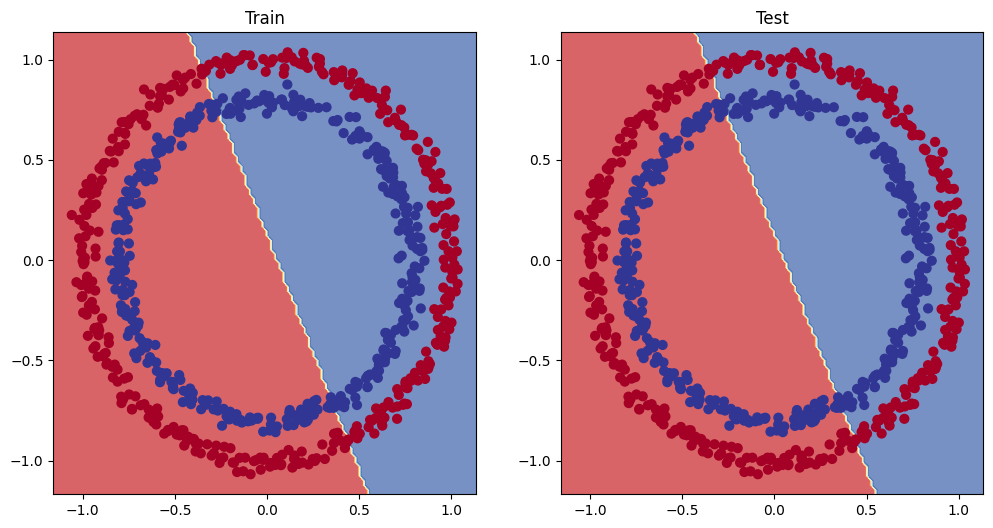

In [33]:
# plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_train, y_train)